# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></div><div class="lev1 toc-item"><a href="#Useful-Scripts" data-toc-modified-id="Useful-Scripts-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Useful Scripts</a></div><div class="lev1 toc-item"><a href="#Load-the-data" data-toc-modified-id="Load-the-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load the data</a></div><div class="lev1 toc-item"><a href="#Add-some-polynomial-features" data-toc-modified-id="Add-some-polynomial-features-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Add some polynomial features</a></div><div class="lev1 toc-item"><a href="#Correlation" data-toc-modified-id="Correlation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Correlation</a></div><div class="lev1 toc-item"><a href="#Train-test-split" data-toc-modified-id="Train-test-split-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Train test split</a></div><div class="lev1 toc-item"><a href="#Baseline-Regression" data-toc-modified-id="Baseline-Regression-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Baseline Regression</a></div><div class="lev1 toc-item"><a href="#Feature-Selection:-SelectKBest" data-toc-modified-id="Feature-Selection:-SelectKBest-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Feature Selection: SelectKBest</a></div><div class="lev1 toc-item"><a href="#Feature-Selection:-RFE-Recursive-Feature-Elimination" data-toc-modified-id="Feature-Selection:-RFE-Recursive-Feature-Elimination-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Feature Selection: RFE Recursive Feature Elimination</a></div><div class="lev1 toc-item"><a href="#Feature-Selection:-RFE-with-cv" data-toc-modified-id="Feature-Selection:-RFE-with-cv-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Feature Selection: RFE with cv</a></div>

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (12,8)})
matplotlib.rcParams['figure.figsize'] = 12,8

import os
import time

# random state
random_state=100
np.random.seed=random_state
np.random.set_state=random_state

# Jupyter notebook settings for pandas
#pd.set_option('display.float_format', '{:,.2g}'.format) # numbers sep by comma
np.set_printoptions(precision=3)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100) # None for all the rows
pd.set_option('display.max_colwidth', 200)

import IPython
from IPython.display import display, HTML, Image, Markdown

print([(x.__name__,x.__version__) for x in [np, pd,sns,matplotlib]])

[('numpy', '1.15.4'), ('pandas', '0.24.2'), ('seaborn', '0.9.0'), ('matplotlib', '2.2.4')]


In [2]:
# split
from sklearn.model_selection import train_test_split

In [3]:
# classifier
from sklearn.linear_model import LogisticRegression

In [4]:
# feature selection
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, chi2

In [5]:
# metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import f1_score,confusion_matrix

# Useful Scripts

In [6]:
def show_method_attributes(method, ncols=7):
    """ Show all the attributes of a given method.
    Example:
    ========
    show_method_attributes(list)
     """
    x = [i for i in dir(method) if i[0]!='_' ]
    x = [i for i in x 
         if i not in 'os np pd sys time psycopg2'.split()
        ]
             

    return pd.DataFrame(np.array_split(x,ncols)).T.fillna('')

In [7]:
df_eval = pd.DataFrame({'Model': [],
                        'Accuracy':[],
                        'F-score':[]})

def get_model_evaluation(desc, model, Xtest,ytest,df_eval):
    from IPython.display import display
    
    acc = accuracy_score(ytest,model.predict(Xtest))
    f1 = f1_score(ytest,model.predict(Xtest))

    df_eval.loc[len(df_eval)] = [desc, acc,f1]
    df_eval = df_eval.drop_duplicates()
    
    df_eval_style = (df_eval.sort_values('F-score',ascending=False)
                     .style
                     .background_gradient(subset=['F-score'])
                    )
    
    display(df_eval_style)
    
    return df_eval

# Load the data

In [8]:
df = pd.read_csv('data/diabetes.csv')
print(df.shape)
df.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [9]:
target = 'Outcome'
df[target].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

# Add some polynomial features

In [10]:
df['BloodPressureSquare'] = np.square(df['BloodPressure'])
df['BloodPressureCube'] = df['BloodPressure']**3
df['BloodPressureSqrt'] = np.sqrt(df['BloodPressure'])

df['GlucoseSquare'] = np.square(df['Glucose'])
df['GlucoseCube'] = df['Glucose']**3
df['GlucoseSqrt'] = np.sqrt(df['Glucose'])

df['GlucoseBloodPressure'] = df['BloodPressure'] * df['Glucose']
df['AgeBMI'] = df['Age'] * df['BMI']

df.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BloodPressureSquare,BloodPressureCube,BloodPressureSqrt,GlucoseSquare,GlucoseCube,GlucoseSqrt,GlucoseBloodPressure,AgeBMI
0,6,148,72,35,0,33.6,0.627,50,1,5184,373248,8.485281,21904,3241792,12.165525,10656,1680.0
1,1,85,66,29,0,26.6,0.351,31,0,4356,287496,8.124038,7225,614125,9.219544,5610,824.6


In [11]:
cols_num = df.select_dtypes('number').columns.tolist()
cols_num;

In [12]:
features = df.columns.difference([target]).values.tolist()
features;

# Correlation

In [13]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome',
       'BloodPressureSquare', 'BloodPressureCube', 'BloodPressureSqrt',
       'GlucoseSquare', 'GlucoseCube', 'GlucoseSqrt', 'GlucoseBloodPressure',
       'AgeBMI'],
      dtype='object')

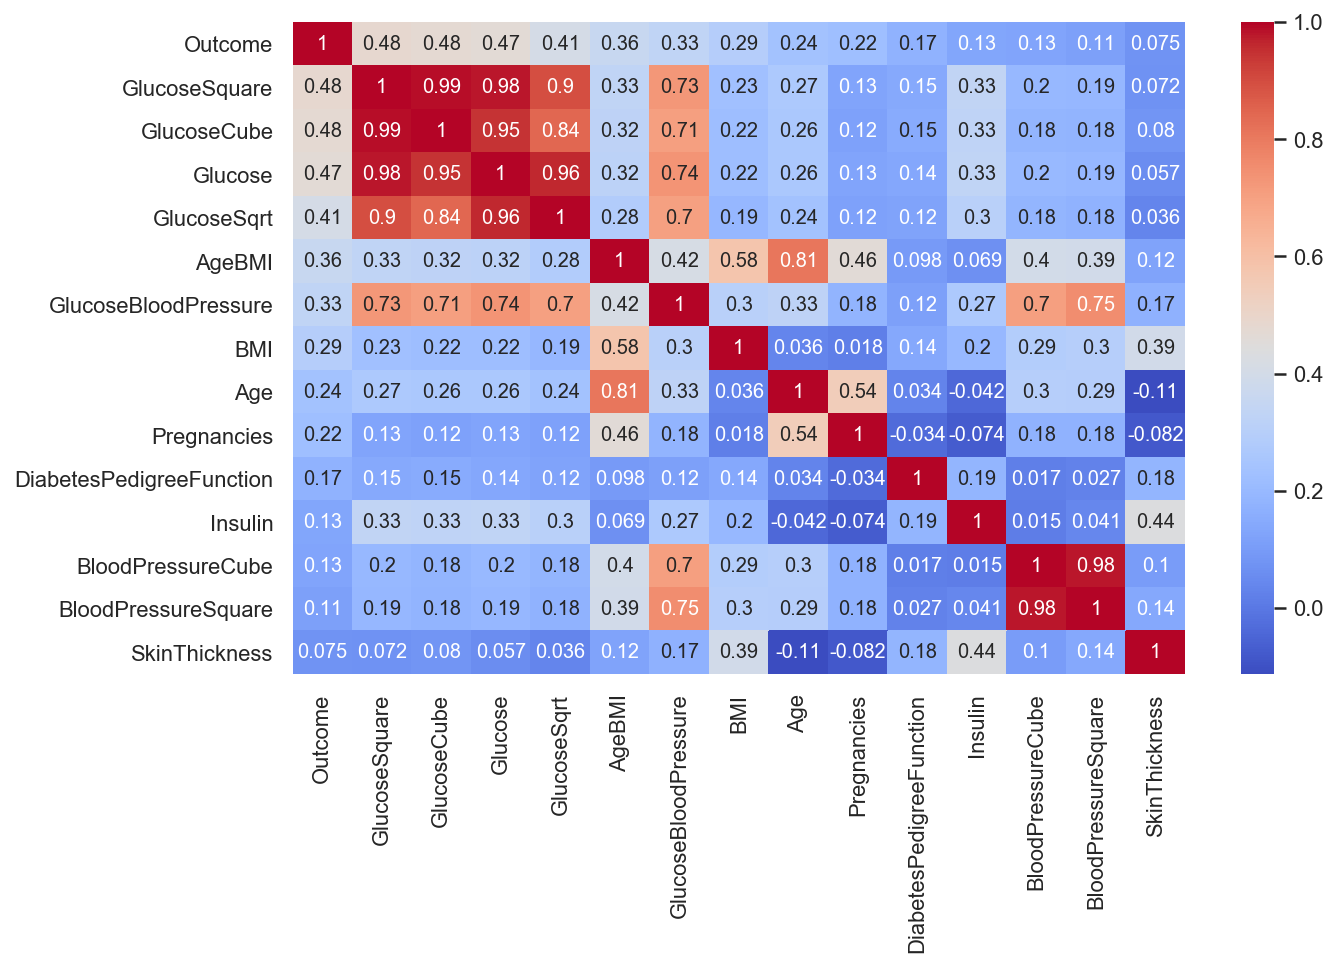

In [14]:
top_n = 15
cols = df[cols_num].corr().nlargest(top_n, target)[target].index
cm = df[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'coolwarm')

# Train test split

In [15]:
X = df.loc[:, df.columns != target]
y = df.loc[:, df.columns == target]

X.shape, y.shape

((768, 16), (768, 1))

In [16]:
# for imbalanced dataset, it is good to use stratify.
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=random_state,
                                               stratify=y)

ytrain = ytrain.values.ravel()
Xtrain.shape, ytrain.shape

((614, 16), (614,))

# Baseline Regression

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import f1_score,confusion_matrix

clf_lr = LogisticRegression(random_state=random_state, n_jobs=-1,solver='lbfgs')

model = clf_lr.fit(Xtrain,ytrain)

In [18]:
df_eval= get_model_evaluation('Logistic Regression with stratify',model, Xtest,ytest,df_eval)

,Model,Accuracy,F-score
0,Logistic Regression with stratify,0.772727,0.597701


In [19]:
confusion_matrix(ytest, model.predict(Xtest))

array([[93,  7],
       [28, 26]])

# Feature Selection: SelectKBest
<br > Feature - Cat,     Target - Cat ==> Chi-Square <br /> 
<br > Feature - Numeric, Target - Numeric ==> Correlation <br /> 
<br > Feature - Cat,     Target - Numeric ==> f_regression <br /> 
<br > Feature - Numeric, Target - Cat ==> f_classification <br /> 

In [20]:
from sklearn.feature_selection import SelectKBest, chi2

kbest = SelectKBest(chi2, k=10,).fit(Xtrain, ytrain)

In [21]:
df_kbest = pd.DataFrame({'Feature':list(Xtrain.columns),
                                     'Scores':kbest.scores_})

df_kbest = df_kbest.sort_values(by='Scores', ascending=False).reset_index()

df_kbest.style.background_gradient(subset=['Scores'])

,index,Feature,Scores
0,12,GlucoseCube,1.81881e+08
1,9,BloodPressureCube,1.47694e+06
2,11,GlucoseSquare,592861
3,14,GlucoseBloodPressure,99501.7
4,15,AgeBMI,15084.7
5,8,BloodPressureSquare,7694.35
6,4,Insulin,1130.39
7,1,Glucose,1112.68
8,5,BMI,126.151
9,7,Age,122.752


In [22]:
show_method_attributes(kbest)

,0,1,2,3,4,5,6
0,fit,get_params,inverse_transform,pvalues_,scores_,set_params,transform
1,fit_transform,get_support,k,score_func,,,


In [23]:
kbest.k

10

In [24]:
Xtrain_chi = kbest.transform(Xtrain)
Xtest_chi = kbest.transform(Xtest)

In [25]:
Xtrain.shape, Xtrain_chi.shape

((614, 16), (614, 10))

In [26]:
model_lr_chi = clf_lr.fit(Xtrain_chi,ytrain)

In [27]:
df_eval = get_model_evaluation('Select kBest = 10',
                     model_lr_chi, Xtest_chi,ytest,df_eval)

,Model,Accuracy,F-score
1,Select kBest = 10,0.779221,0.604651
0,Logistic Regression with stratify,0.772727,0.597701


# Feature Selection: RFE Recursive Feature Elimination

In [28]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=clf_lr, step=1)
rfe = rfe.fit(Xtrain, ytrain)

In [29]:
show_method_attributes(model)

,0,1,2,3,4,5,6
0,C,densify,get_params,max_iter,penalty,random_state,sparsify
1,class_weight,dual,intercept_,multi_class,predict,score,tol
2,classes_,fit,intercept_scaling,n_iter_,predict_log_proba,set_params,verbose
3,coef_,fit_intercept,l1_ratio,n_jobs,predict_proba,solver,warm_start
4,decision_function,,,,,,


In [30]:
df_rfe = pd.DataFrame({'Feature':list(Xtrain.columns),
                                      'Ranking':rfe.ranking_})
df_rfe.sort_values(by='Ranking').reset_index()

,index,Feature,Ranking
0,0,Pregnancies,1
1,1,Glucose,1
2,2,BloodPressure,1
3,5,BMI,1
4,7,Age,1
5,10,BloodPressureSqrt,1
6,13,GlucoseSqrt,1
7,15,AgeBMI,1
8,4,Insulin,2
9,14,GlucoseBloodPressure,3


In [31]:
Xtrain_lr_rfe = rfe.transform(Xtrain)
Xtest_lr_rfe = rfe.transform(Xtest)

Xtrain.shape, Xtrain_lr_rfe.shape

((614, 16), (614, 8))

In [32]:
model_lr_rfe = clf_lr.fit(Xtrain_lr_rfe, ytrain)

In [33]:
df_eval = get_model_evaluation('RFE',
                     model_lr_rfe, Xtest_lr_rfe,ytest,df_eval)

,Model,Accuracy,F-score
2,RFE,0.798701,0.673684
1,Select kBest = 10,0.779221,0.604651
0,Logistic Regression with stratify,0.772727,0.597701


# Feature Selection: RFE with cv

In [34]:
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=clf_lr, step=1, cv=5, scoring='accuracy')
rfecv = rfecv.fit(Xtrain, ytrain)

In [35]:
show_method_attributes(rfecv)

,0,1,2,3,4,5,6
0,classes_,estimator_,get_support,n_features_,predict_proba,scoring,support_
1,cv,fit,grid_scores_,n_jobs,ranking_,set_params,transform
2,decision_function,fit_transform,inverse_transform,predict,score,step,verbose
3,estimator,get_params,min_features_to_select,predict_log_proba,,,


In [36]:
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', Xtrain.columns[rfecv.support_].values)

Optimal number of features : 5
Best features : ['Pregnancies' 'Glucose' 'BMI' 'BloodPressureSqrt' 'GlucoseSqrt']


In [37]:
rfecv.grid_scores_

array([0.743, 0.743, 0.739, 0.769, 0.779, 0.77 , 0.749, 0.752, 0.751,
       0.751, 0.756, 0.749, 0.744, 0.743, 0.751, 0.749])

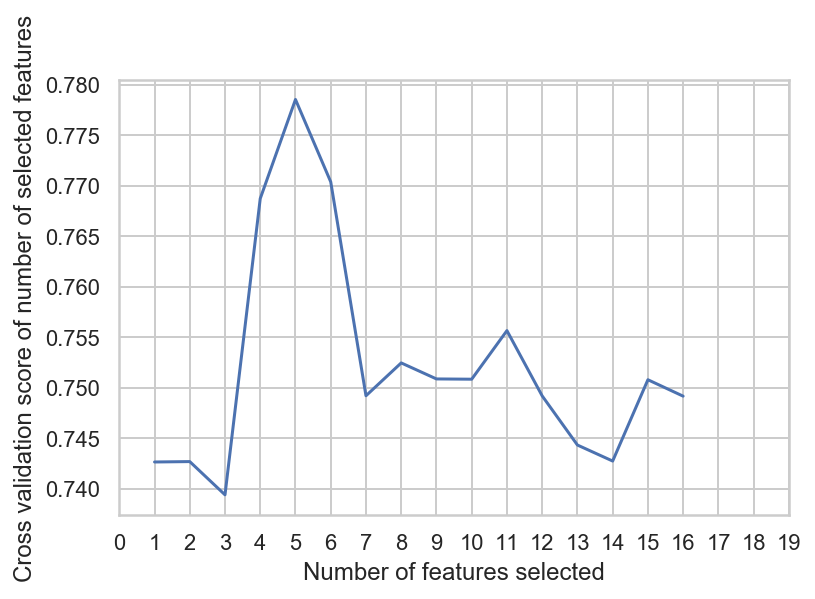

In [38]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.xticks(range(20))
plt.show()

In [39]:
Xtrain_lr_rfecv = rfecv.transform(Xtrain)
Xtest_lr_rfecv = rfecv.transform(Xtest)

In [40]:
model_lr_rfecv = clf_lr.fit(Xtrain_lr_rfecv, ytrain)

In [41]:
df_eval = get_model_evaluation('RFECV',
                     model_lr_rfecv, Xtest_lr_rfecv,ytest,df_eval)

,Model,Accuracy,F-score
2,RFE,0.798701,0.673684
3,RFECV,0.785714,0.652632
1,Select kBest = 10,0.779221,0.604651
0,Logistic Regression with stratify,0.772727,0.597701
